Deprecated, will cleanup later

# Setup

In [2]:
import plotly.io as pio
try:
    import google.colab
    print("Running as a Colab notebook")
    pio.renderers.default = "colab"
    %pip install transformer-lens fancy-einsum
    %pip install -U kaleido # kaleido only works if you restart the runtime. Required to write figures to disk (final cell)
except:
    print("Running as a Jupyter notebook")
    pio.renderers.default = "vscode"
    from IPython import get_ipython
    ipython = get_ipython()

Running as a Jupyter notebook


In [3]:
import torch
from fancy_einsum import einsum
from transformer_lens import HookedTransformer, HookedTransformerConfig, utils, ActivationCache
from torchtyping import TensorType as TT
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import einops
from typing import List, Union, Optional
from functools import partial
import pandas as pd
from pathlib import Path
import urllib.request
from bs4 import BeautifulSoup
from tqdm import tqdm
from datasets import load_dataset
import os
import json

os.environ["TOKENIZERS_PARALLELISM"] = "false" # https://stackoverflow.com/q/62691279
torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
!pip install circuitsvis
import circuitsvis as cv


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [5]:
pio.renderers.default='vscode'

def imshow(tensor, renderer=None, **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

def line(tensor, renderer=None, **kwargs):
    px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [81]:
model = HookedTransformer.from_pretrained(
    "gpt2-large",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
    device=device,
)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-large into HookedTransformer


## Generate Prompts For GPT-4 Example Generation

In [82]:
# Relevant Files
# iteration_prompts_ref_1.pkl is the result, with {head: [positive gen, negative gen, positive evaled, negative evaled]}
# head_explanation_1_nh_to_exp. json is the generated explanation, with {head: "explanation"}

In [6]:
import pickle
with open("data/iteration_prompts_ref_1.pkl", "rb") as f:
    generation_eval = pickle.load(f)

with open("data/head_explanation_1_nh_to_exp.json", "rb") as f:
    nh_to_explanation = json.load(f)

nh_to_explanation = {tuple(int(value.strip()) for value in k.strip('()').split(',')): v for k,v in nh_to_explanation.items()}

with open("data/neuron_finder_results.json", "r") as f:
    neuron_finder_results = json.load(f)

with open("data/head_explanation_1_prompts.json", "r") as f:
    given_categories = json.load(f)

given_categories = {tuple(int(value.strip()) for value in k.strip('()').split(',')): v for k,v in given_categories.items()}

with open("data/categorised_prompts_1.pkl", "rb") as f:
    categorised_prompts = pickle.load(f)


neuron_to_token = {}

for layer in neuron_finder_results.keys():
    for neuron_ind in neuron_finder_results[layer].keys():
        neuron_to_token[(int(layer), int(neuron_ind))] = neuron_finder_results[layer][neuron_ind][0]

with open("data/head_explanation_1_prompts.json", "r") as f:
    max_activating_categorised = json.load(f)

max_activating_categorised = {tuple(int(value.strip()) for value in k.strip('()').split(',')): v for k,v in max_activating_categorised.items()}

In [7]:
accuracies = {}
accuracy_balanced = {}
accuracies_positive = {}
accuracies_negative = {}
f1s = {}
for head, (pred_pos, pred_neg, correct_pos, correct_neg) in generation_eval.items():
    cat_prompts_positive, cat_prompts_negative = categorised_prompts[head]
    # if len(cat_prompts_positive)/(len(cat_prompts_positive)+len(cat_prompts_negative)) > 0.75:
    #     print("SKIP")
    #     continue

    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    for eg in pred_pos:
        if eg in correct_pos:
            true_pos += 1
        else:
            false_pos += 1
    for eg in pred_neg:
        if eg in correct_neg:
            true_neg += 1
        else:
            false_neg += 1

    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
    accuracy_positive = true_pos / (true_pos + false_pos)
    accuracy_negative = true_neg / (true_neg + false_neg)
    precision = true_pos / (true_pos + false_pos)

    # accuracies_positive.append(accuracy_positive)
    accuracies_positive[head] = accuracy_positive
    accuracies_negative[head] = accuracy_negative
    accuracy_balanced[head] = (accuracy_positive+accuracy_negative)/2
    accuracies[head] = (accuracy)
    f1 = 2 * true_pos / (2 * true_pos + false_pos + false_neg)
    f1s[head] = (f1)



print(np.mean(list(accuracies.values())))
print(np.mean(list(accuracies_positive.values())))
print(np.mean(list(accuracies_negative.values())))
print(np.mean(list(f1s.values())))
print(np.mean(list(accuracy_balanced.values())))

0.5884469696969696
0.405965909090909
0.7704545454545454
0.411324878114303
0.5882102272727273


In [8]:
scatter(np.arange(len(f1s.values())), list(f1s.values()))

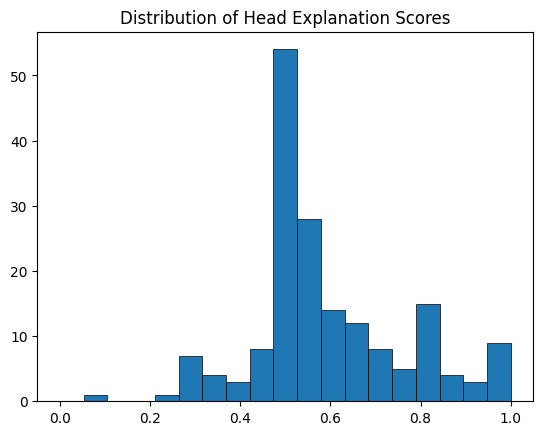

In [9]:
bins = np.linspace(0, 1, 20)
import matplotlib.pyplot as plt
plt.hist(accuracy_balanced.values(), bins, label='Overall Accuracy', linewidth=0.5, edgecolor="black")
plt.title("Distribution of Head Explanation Scores")
plt.savefig("hist.pdf")

In [ ]:
x = list(accuracies_positive.values())
y = list(accuracies_negative.values())
print(list(zip(x, y)))
print(list(f1s.values()))

[(0.0, 1.0), (0.0, 1.0), (1.0, 1.0), (0.4, 0.8), (0.4, 0.1), (0.1, 1.0), (0.9, 1.0), (0.2, 0.4), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.8, 0.9), (0.5, 0.8), (0.1, 0.8), (0.9, 1.0), (0.6, 1.0), (0.6, 1.0), (0.6, 0.0), (0.0, 0.9), (0.6, 1.0), (0.2, 1.0), (0.0, 1.0), (0.0, 0.8), (0.2, 0.5), (0.3, 0.8), (0.2, 1.0), (0.3, 0.4), (0.1, 1.0), (0.6, 1.0), (0.1, 1.0), (0.7, 0.9), (0.6, 1.0), (0.7, 0.7), (0.1, 0.8), (0.5, 0.8), (0.6, 0.7), (0.1, 1.0), (0.7, 0.8), (0.7, 0.4), (0.6, 0.8), (0.7, 1.0), (0.8, 0.4), (1.0, 0.3), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.8, 0.2), (0.3, 0.7), (0.7, 0.9), (0.9, 0.3), (0.5, 0.6), (0.8, 0.7), (0.0, 0.9), (0.4, 0.8), (0.0, 1.0), (0.6, 0.8), (0.9, 0.4), (0.4, 1.0), (0.2, 1.0), (0.5, 0.8), (0.6, 1.0), (0.3, 0.8), (0.0, 1.0), (0.5, 1.0), (0.0, 1.0), (0.1, 1.0), (0.4, 0.2), (0.3, 1.0), (0.0, 1.0), (0.3, 0.8), (0.0, 1.0), (1.0, 0.0), (0.0, 1.0), (0.0, 1.0), (0.2, 0.9), (0.4, 0.8), (0.5, 0.8), (0.6, 0.8), (0.5, 1.0), (0.3, 1.0), (1.0, 0.0), (0.

In [260]:
(grid[6:, 6:].sum() / grid.sum()) * 100

21.59090909090909

[0.0, 0.0, 1.0, 0.4, 0.4, 0.1, 0.9, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 0.5, 0.1, 0.9, 0.6, 0.6, 0.6, 0.0, 0.6, 0.2, 0.0, 0.0, 0.2, 0.3, 0.2, 0.3, 0.1, 0.6, 0.1, 0.7, 0.6, 0.7, 0.1, 0.5, 0.6, 0.1, 0.7, 0.7, 0.6, 0.7, 0.8, 1.0, 0.0, 0.0, 0.0, 0.8, 0.3, 0.7, 0.9, 0.5, 0.8, 0.0, 0.4, 0.0, 0.6, 0.9, 0.4, 0.2, 0.5, 0.6, 0.3, 0.0, 0.5, 0.0, 0.1, 0.4, 0.3, 0.0, 0.3, 0.0, 1.0, 0.0, 0.0, 0.2, 0.4, 0.5, 0.6, 0.5, 0.3, 1.0, 0.9, 0.6, 0.3, 0.0, 0.1, 0.1, 0.4, 0.3, 0.0, 0.4, 0.0, 0.0, 0.2, 0.0, 0.5, 0.7, 0.0, 0.0, 0.0, 0.3, 1.0, 0.0, 0.0, 0.6, 0.9, 0.7, 0.0, 0.0, 0.9, 0.0, 0.0, 0.0, 0.9, 0.1, 0.0, 1.0, 0.9, 0.8, 0.0, 1.0, 0.5, 0.0, 0.0, 0.7, 1.0, 0.0, 0.0, 0.0, 1.0, 0.2, 0.4, 0.2, 0.3, 1.0, 0.0, 0.2, 0.6, 0.2, 0.7, 0.0, 0.6, 0.0, 1.0, 0.3, 1.0, 0.7, 0.4, 0.0, 0.1, 0.5, 0.45, 0.0, 0.0, 0.0, 0.3, 0.4]
[(0.0, 1.0), (0.0, 1.0), (1.0, 1.0), (0.4, 0.8), (0.4, 0.1), (0.1, 1.0), (0.9, 1.0), (0.2, 0.4), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.8, 0.9), (0.5, 0.8), (0.1, 0.8), (0.9, 1.0)

[Text(0.5, 1.0, 'Distribution of True Positive and True Negative Rates over all heads\n')]

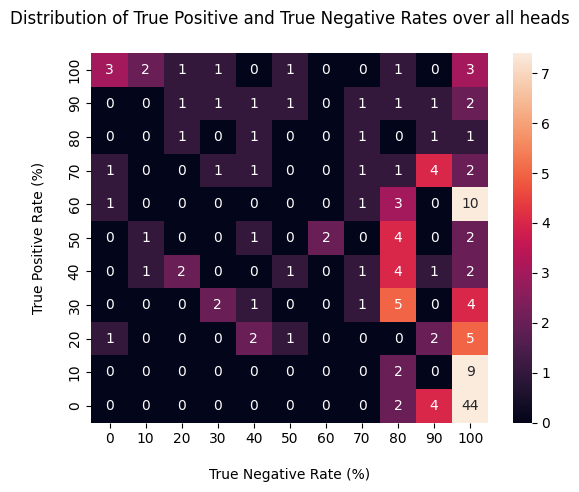

In [261]:

import seaborn as sb

# Create a 2D array filled with zeros
grid = np.zeros((11, 11), dtype=int)
print(x)

# Iterate through the values in x and y
zipped_list = list(zip(x, y))
print(zipped_list)
for x_item, y_item in zipped_list:
    # Iterate through the values in x and y
    # Increment the count in the grid at the corresponding position
    grid[int(x_item*10), int(y_item*10)] +=  1


ax = sb.heatmap(grid, annot=True, robust=True, xticklabels=[i*10 for i in range(11)], yticklabels=[i*10 for i in range(11)])
ax.invert_yaxis()
ax.set(xlabel="\nTrue Negative Rate (%)", ylabel="True Positive Rate (%)\n")
ax.set(title="Distribution of True Positive and True Negative Rates over all heads\n")

In [11]:
tnr = 10
tpr = 10

head_list = []
for head, accuracy_positive in accuracies_positive.items():
    accuracy_negative = accuracies_negative[head]
    if int(accuracy_positive * 10) == tpr and int(accuracy_negative * 10) == tnr:
        head_list.append(head)

print(head_list)
print(len(head_list))


[(31, 3621, 538), (32, 3151, 546), (32, 3151, 496), (34, 4410, 604), (35, 3360, 691), (35, 885, 549)]
6


In [ ]:
print(len(categorised_prompts[(31, 3621, 468)]))

2


In [15]:
def get_head_results(nh, gen_results, nh_to_exp, neuron_to_token, categorised_prompts):
    gen_positive, gen_negative, eval_positive, eval_negative = gen_results[nh]
    balanced_accuracy = accuracy_balanced[nh]

    return_str = f"## {nh} — {balanced_accuracy:.2f} Accuracy \n"
    return_str += f'Neuron helps to predict the token "{neuron_to_token[(nh[0],nh[1])]}".\n'
    positive_egs, negative_egs = categorised_prompts[nh]

    return_str += f"\n### Max-Activating Data from The Pile\n"

    return_str += "Examples where the attention head is active:\n"
    for i, positive_eg in enumerate(positive_egs):
        return_str += f"{i}. {positive_eg}\n"

    return_str += "\nExamples where the attention head is inactive:\n"
    for i, negative_eg in enumerate(negative_egs):
        return_str += f"{i}. {negative_eg}\n"

    return_str += f"\nGPT-4's Explanation: \n   The head is active when the document {nh_to_exp[nh]}\n"

    return_str += f"\n### Synthetic Data from GPT-4\n"

    return_str += "Examples where the attention head is active:\n"
    for i, eg in enumerate(gen_positive):
        return_str += f"{i}. "
        if eg in eval_positive:
            return_str += "✅ "
        else:
            return_str += "❌ "
        return_str += f"{eg}\n"
    return_str += "\nExamples where the attention head is inactive:\n"
    for i, eg in enumerate(gen_negative):
        return_str += f"{i}. "
        if eg in eval_negative:
            return_str += "✅ "
        else:
            return_str += "❌ "
        return_str += f"{eg}\n"
    
    return balanced_accuracy, return_str

accuracy, result = get_head_results(head_list[3], generation_eval, nh_to_explanation, neuron_to_token, categorised_prompts)

print(result)

## (34, 4410, 604) — 1.00 Accuracy 
Neuron helps to predict the token " as".

### Max-Activating Data from The Pile
Examples where the attention head is active:
0.  could begin as early as
1.  kindergarteners that will be available in schools as early as
2.  The lead would reach as high as
3.  by the permanently dependent. Until they finish burying the Constitution, which Obama will do as fast as
4.  expand its conference championship sports to 23 -- seven more than when the league began in 2013 -- as early as

Examples where the attention head is inactive:
0.  soon as it's published, (typically within 48 hours). We really value your contributions, and so does our community of business professionals. They count on honest reviews like yours.  Thanks for submitting your review of Triton Benefits & HR Solutions.  We'll email you as soon as
1.  greed, as well as fashion. I'm not condeming what you said either, I'm just pointing out different sides.  nyan nyan percent  But do you wear leath

In [19]:
overview_list = []

for head, accuracy_positive in accuracies_positive.items():
    accuracy, result = get_head_results(head, generation_eval, nh_to_explanation, neuron_to_token, categorised_prompts)
    overview_list.append((accuracy, head, result))

# Sort overview list by first element
overview_list.sort(key=lambda x: x[0], reverse=True)

# Save overview list strings to text file
with open("overview.txt", "w") as f:
    for accuracy, head, result in overview_list:
        f.write(result)
        f.write("\n\n")

In [41]:
ind = 0

In [ ]:
## (31, 3621, 538) — 1.00 Accuracy — for x purposes "only"
## (32, 3151, 546) — 1.00 Accuracy — over and "over"
## (32, 3151, 496) — 1.00 Accuracy — over and "over"
## (34, 4410, 604) — 1.00 Accuracy – as fast/early/high "as"
## (35, 3360, 691) — 1.00 Accuracy — by the "very"... over -> it was very, "very"
## (35, 885, 549) — 1.00 Accuracy — Sentence... "His"
## (31, 364, 548) — 0.95 Accuracy — The number of a document e.g. IMEI "number" passport "number", mobile "number", etc.
## (31, 4378, 123) — 0.95 Accuracy — ... Taken "together"
## (31, 4941, 538) — 0.95 Accuracy — "within" x amount of time
## (34, 5095, 538) — 0.90 Accuracy — working "well", responding "well" — specifically for positive contexts
## (34, 4494, 658) — 0.90 Accuracy — U. S. Pat "no" — specifically for US Patents only
## (34, 4494, 160) — 0.90 Accuracy — U. S. Pat "no" — specifically for US Patents only
## (31, 4378, 538) — 0.85 Accuracy — Bring "together", put two and two "together" — for contexts about merging or joining
## (34, 4494, 641) — 0.90 Accuracy — U. S. Pat "no" — specifically for US Patents only
## (32, 4964, 492) — 0.85 Accuracy — "too" — excessive contexts?
## (35, 5014, 504) — 0.85 Accuracy — " won" — the examples are <won>'t, but GPT-4 doesn't understand that
## (31, 4378, 106) — 0.80 Accuracy — taken "together"
## (31, 4378, 88) — 0.80 Accuracy — taken "together"
## (31, 988, 371) — 0.80 Accuracy — also "called"
## (31, 2692, 559) — 0.80 Accuracy — past vs present e.g. what it "used" to be
## (31, 4941, 466) — 0.80 Accuracy — deadline or timeframe
## (32, 406, 538) — 0.80 Accuracy — ...as "much"
## (33, 4900, 492) — 0.80 Accuracy — a measurement "of"
## (34, 4262, 538) — 0.80 Accuracy — verb "down" e.g. watered down, gunned down
## (34, 4199, 538) — 0.80 Accuracy — sought-" after"

In [74]:
for i, (accuracy, head, result) in enumerate(overview_list):
    if ind != i: 
        continue
    else:
        print(result)
        ind += 1
        break

## (32, 4882, 489) — 0.75 Accuracy 
Neuron helps to predict the token " class".

### Max-Activating Data from The Pile
Examples where the attention head is active:
0.  went to teach a yoga class
1.  evening classes in May 2012, followed by morning class
2.  kind of thing you learn about in introductory general physics class
3.  Science course apart. The once-a-week class
4.  teaching a music-appreciation class
5.  include syllabi and promotional flyers for the first women's studies class
6.  attend gender studies class
7.  general education classroom to do a co-teaching lesson in my classroom. This way I get the opportunity to collaborate with my general education class
8.  am planning on teaching an intro to “Programming for Informaticists” class
9.  not teach headstand in my class

Examples where the attention head is inactive:
0.  teacher who noticed that I was fooling around at the back of the class
1.  an aerobics class
2.  always dabbled. I took a couple soapmaking class
3.  copi

Text(0.5, 1.0, 'Positive Accuracy (Pre_Iteration)')

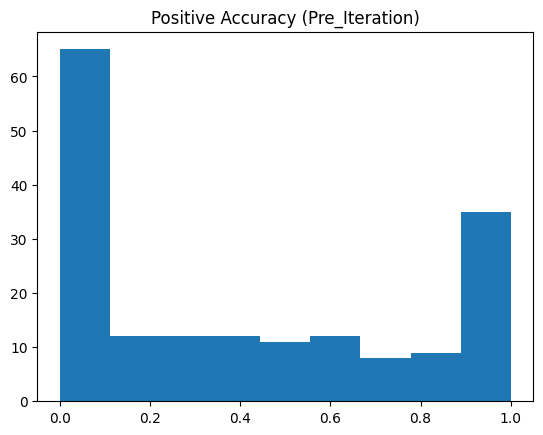

In [84]:
plt.hist(accuracies_positive.values(), bins, label='Positive Accuracy')
plt.title("Positive Accuracy (Pre_Iteration)")

In [63]:
scatter(np.arange(len(accuracies_positive)), list(accuracies_positive.values()), hover_name=labels, title="Accuracy of Positive Generation (Pre-Iteration)",range_y=[-0.1,1.1])

In [64]:
accuracies = []
accuracies_positive = {}
accuracies_negative = []
f1s = []
precisions = []
recalls = []
for head, (pred_pos, pred_neg, correct_pos, correct_neg) in v2.items():
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    for eg in pred_pos:
        if eg in correct_pos:
            true_pos += 1
        else:
            false_pos += 1
    for eg in pred_neg:
        if eg in correct_neg:
            true_neg += 1
        else:
            false_neg += 1
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
    accuracy_positive = true_pos / (true_pos + false_pos)
    accuracy_negative = true_neg / (true_neg + false_neg)
    precision = true_pos / (true_pos + false_pos)
    try:
        recall = true_pos / (true_pos + false_neg)
        recalls.append(recall)
    except ZeroDivisionError:
        pass
    precisions.append(precision)

    # accuracies_positive.append(accuracy_positive)
    accuracies_positive[head] = accuracy_positive
    accuracies_negative.append(accuracy_negative)
    accuracies.append(accuracy)
    f1 = 2 * true_pos / (2 * true_pos + false_pos + false_neg)
    f1s.append(f1)



print(np.mean(accuracies))
print(np.mean(list(accuracies_positive.values())))
print(np.mean(accuracies_negative))
print(np.mean(f1s))
print(np.mean(precisions))
print(np.mean(recalls))

0.5954229797979799
0.4034090909090909
0.7856534090909091
0.40573377829807455
0.4034090909090909
0.6660497535647056


In [65]:
scatter(np.arange(len(accuracies)), accuracies, title="Overall Accuracy (Post_Iteration)",range_y=[-0.1,1.1])

In [66]:
scatter(np.arange(len(accuracies_positive)), list(accuracies_positive.values()), hover_name=labels, title="Accuracy of Positive Generation (Post-Iteration)", range_y=[-0.1,1.1]) # add hover